In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from nltk.corpus import stopwords
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis.gensim as gensimvis
from gensim.models.ldamulticore import LdaMulticore
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS
from pprint import pprint
import pyLDAvis
pyLDAvis.enable_notebook()
import pickle
%matplotlib inline
sns.set()
# Set the style of plots
plt.style.use('fivethirtyeight')

stop_words = stopwords.words('english')
nlp = spacy.load("en_core_web_lg", disable=['parser', 'ner'])

df = pd.read_csv('data/sources/listings.csv.gz', low_memory=False, usecols=['id', 'description'])
df.head()

,id,description
0,16228948,Stunning Ranch Estate situated on 20 acres and...
1,8909380,Very private and quite . Hiking horse riding a...
2,14078522,My place is close to Six Flags Magic Mountain ...
3,13006928,"Our place is close to great views, equestrian ..."
4,7898757,Fully furnished studio only a 10 min drive fro...


In [2]:
# Turn the description column into a list of strings
data = df.description.values.tolist()

In [3]:
# Turn each sentence into tokens and remove punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield (gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(data))

In [4]:
# Save the data_words list
with open("data/processed/nlp/nlp_data_words.pkl", "wb") as fp:
    pickle.dump(data_words,fp)

# Gensim

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Save each gram model
bigram_mod.save("data/processed/nlp/my_bigram_model.pkl")
trigram_mod.save("data/processed/nlp/my_trigram_model.pkl")

# Reload the gram models
#bigram_reloaded = Phraser.load("/tmp/my_bigram_model.pkl")
#trigram_reloaded = Phraser.load("/tmp/my_trigram_model.pkl")

In [6]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams)

In [8]:
# save the lemmatized token list
with open("data/processed/nlp/nlp_lemmatized.pkl", "wb") as fp:
    pickle.dump(data_lemmatized,fp)

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [10]:
# Save the corpus
id2word.save('data/processed/nlp/nlp_dictionary.pkl')

# Optimize

In [12]:
def compute_coherence_values(dictionary,
                             corpus,
                             texts,
                             limit,
                             start=2,
                             step=3,
                             coherence='c_v'):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=num_topics,
                                                random_state=1234,
                                                chunksize=100,
                                                passes=10,
                                                alpha=.5,
                                                per_word_topics=True,
                         workers=7)
        model_list.append(model)
        coherencemodel=CoherenceModel(model = model,
                                        texts = texts,
                                        dictionary = dictionary,
                                        coherence = coherence)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [13]:
limit = 16
start = 2
step = 1

## c_v coherence score

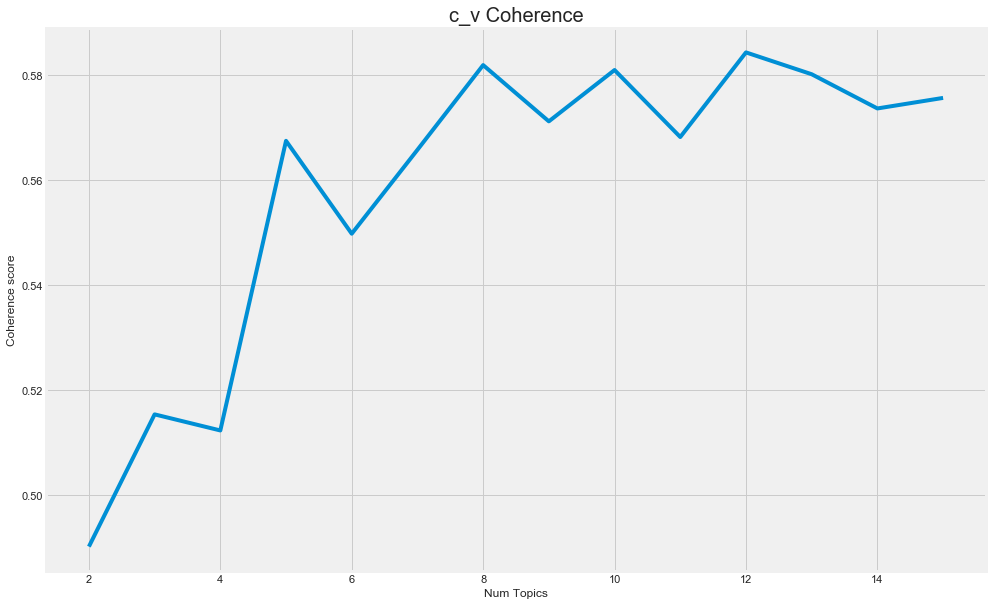

In [14]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step)

x = range(start, limit, step)
fig = plt.figure(figsize=(15,10))
sns.lineplot(x, coherence_values)
plt.title('c_v Coherence', fontsize=20)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.savefig('img/nlp_cv_coherence.png', bbox_inches='tight', pad_inches=.2)
plt.show()

## u-mass coherence score

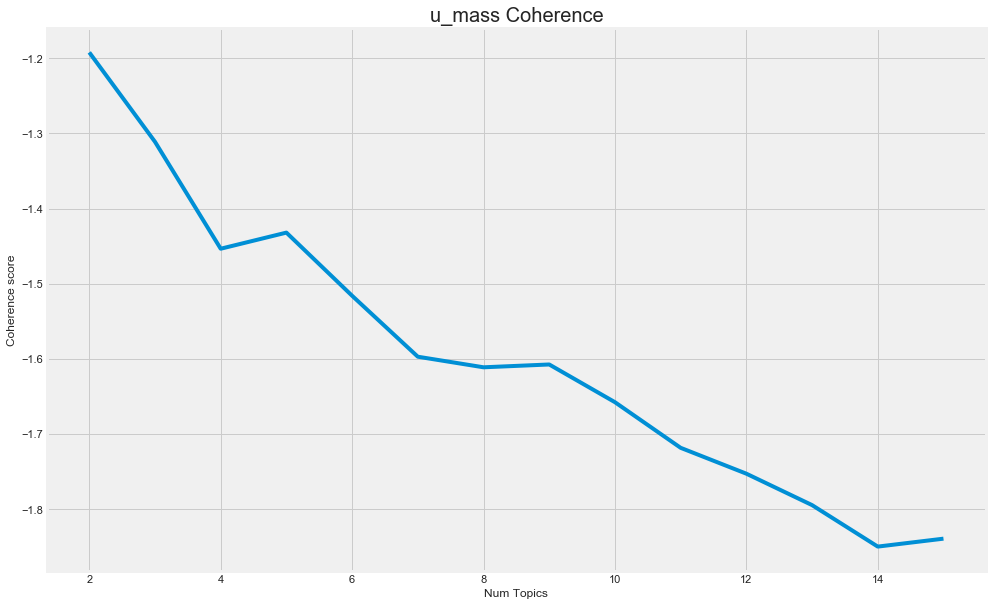

In [15]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        limit=limit,
                                                        step=step,
                                                        coherence='u_mass')

x = range(start, limit, step)
fig = plt.figure(figsize=(15,10))
plt.plot(x, coherence_values)
plt.title('u_mass Coherence', fontsize=20)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.savefig('img/nlp_umass_coherence.png', bbox_inches='tight', pad_inches=.2)
plt.show()

# Final Model build

In [17]:
lda_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=8,
                         random_state=1234,
                         chunksize=100,
                         passes=10,
                         per_word_topics=True,
                         alpha=.5,
                         workers=7)

In [18]:
pprint(lda_model.print_topics(num_words=10))

[(0,
  '0.019*"home" + 0.016*"enjoy" + 0.014*"space" + 0.011*"relax" + '
  '0.011*"private" + 0.011*"garden" + 0.010*"perfect" + 0.009*"view" + '
  '0.009*"beautiful" + 0.009*"studio"'),
 (1,
  '0.025*"home" + 0.023*"large" + 0.019*"bedroom" + 0.019*"view" + '
  '0.018*"outdoor" + 0.017*"area" + 0.016*"private" + 0.015*"patio" + '
  '0.015*"room" + 0.015*"pool"'),
 (2,
  '0.078*"room" + 0.045*"private" + 0.038*"bathroom" + 0.028*"bedroom" + '
  '0.028*"kitchen" + 0.027*"share" + 0.026*"access" + 0.020*"guest" + '
  '0.020*"quiet" + 0.018*"living"'),
 (3,
  '0.076*"bed" + 0.037*"room" + 0.032*"size" + 0.027*"bedroom" + 0.024*"full" '
  '+ 0.024*"queen" + 0.022*"bathroom" + 0.017*"kitchen" + 0.016*"large" + '
  '0.013*"shower"'),
 (4,
  '0.021*"stay" + 0.020*"guest" + 0.018*"available" + 0.017*"home" + '
  '0.014*"need" + 0.012*"time" + 0.010*"day" + 0.010*"check" + 0.009*"house" + '
  '0.009*"use"'),
 (5,
  '0.048*"place" + 0.043*"restaurant" + 0.043*"walk" + 0.030*"minute" + '
  '0.028

In [19]:
gensimvis.prepare(lda_model, corpus, id2word)

C:\Users\peril\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.248269 -0.014853       1        1  15.839013
4     -0.183157 -0.028160       2        1  13.337792
2     -0.030835  0.102410       3        1  13.136937
0     -0.013131 -0.246530       4        1  12.530366
3      0.183701  0.116998       5        1  12.427424
1      0.188372 -0.137717       6        1  11.852648
6      0.129211  0.005845       7        1  10.469266
7     -0.025893  0.202007       8        1  10.406547, topic_info=     Category          Freq        Term         Total  loglift  logprob
96    Default  17785.000000         bed  17785.000000  30.0000  30.0000
30    Default  29371.000000        room  29371.000000  29.0000  29.0000
161   Default  14331.000000   apartment  14331.000000  28.0000  28.0000
74    Default  14400.000000       place  14400.000000  27.0000  27.0000
309   Default   8020.000000         new   8020.000000  26.0000  26.0000
209   Default  13605.000000     parking  13605.000000  25.0000  25.0000
451   Default  13843.000000  restaurant  13843.000000  24.0000  24.0000
8     Default  21380.000000     bedroom  21380.000000  23.0000  23.0000
162   Default  15738.000000    bathroom  15738.000000  22.0000  22.0000
47    Default  20846.000000     private  20846.000000  21.0000  21.0000
158   Default   7248.000000        size   7248.000000  20.0000  20.0000
169   Default   6610.000000       share   6610.000000  19.0000  19.0000
204   Default   7107.000000        free   7107.000000  18.0000  18.0000
197   Default  17525.000000        walk  17525.000000  17.0000  17.0000
606   Default   8434.000000    distance   8434.000000  16.0000  16.0000
123   Default   5356.000000       queen   5356.000000  15.0000  15.0000
617   Default   6108.000000        unit   6108.000000  14.0000  14.0000
68    Default   9040.000000        good   9040.000000  13.0000  13.0000
150   Default  10127.000000       large  10127.000000  12.0000  12.0000
38    Default  11385.000000       close  11385.000000  11.0000  11.0000
164   Default  18833.000000     kitchen  18833.000000  10.0000  10.0000
220   Default   4931.000000       dryer   4931.000000   9.0000   9.0000
99    Default   4695.000000    business   4695.000000   8.0000   8.0000
21    Default  15847.000000        home  15847.000000   7.0000   7.0000
506   Default   6338.000000        shop   6338.000000   6.0000   6.0000
132   Default   4531.000000    traveler   4531.000000   5.0000   5.0000
308   Default   5023.000000      modern   5023.000000   4.0000   4.0000
166   Default  11487.000000      minute  11487.000000   3.0000   3.0000
432   Default   7629.000000          tv   7629.000000   2.0000   2.0000
147   Default  12365.000000        full  12365.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
476    Topic8   1824.608887       towel   2930.113281   1.7891  -4.5865
609    Topic8   1497.155640        gate   2393.956299   1.7934  -4.7843
159    Topic8   3251.939209      studio   6081.172363   1.6368  -4.0086
432    Topic8   3801.423096          tv   7629.558594   1.5661  -3.8525
1393   Topic8    538.194336     utensil    749.691284   1.9313  -5.8074
301    Topic8   3738.219482     include   8269.265625   1.4688  -3.8692
666    Topic8    741.992554         tea   1132.882568   1.8396  -5.4863
516    Topic8   2324.203369     provide   4770.016113   1.5438  -4.3445
19     Topic8   1208.970459         gym   2165.379883   1.6799  -4.9981
151    Topic8   1760.120117     laundry   3514.666504   1.5712  -4.6225
2053   Topic8    933.617371       maker   1564.753418   1.7463  -5.2565
493    Topic8   2443.299316      coffee   5848.473633   1.3899  -4.2945
223    Topic8   1230.439209      garage   2378.127930   1.6038  -4.9805
4      Topic8   1675.151978     amenity   3710.134033   1.4676  -4.6720
397    Topic8   1125.522949   microwave   2167.205322   1.6075  -5.0696
617    Topic8   2192.467529      

# Connect topics to main data

In [20]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=texts):
    # Array of top 10 topics
    top10array = []

    for row in range(ldamodel.num_topics):
        wp = ldamodel.show_topic(row)
        topic_keywords = ", ".join([word for word, prop in wp])
        top10array.append((row+1, topic_keywords))

    top10dict = dict(top10array)

    sent_topics_df = pd.DataFrame(pd.DataFrame([sorted(topic[0], key=lambda x: (x[1]), reverse=True) for topic in ldamodel[corpus]])[0])
    sent_topics_df.columns=["Data"]
    sent_topics_df['Dominant_Topic'] = sent_topics_df.Data.apply(lambda x: x[0]+1)
    sent_topics_df['Perc_Contribution'] = sent_topics_df.Data.apply(lambda x: round(x[1],4))
    sent_topics_df['Topic_Keywords'] = sent_topics_df.Dominant_Topic.apply(lambda x: top10dict[x])

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename("Text")], axis=1)
    sent_topics_df = sent_topics_df[['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']]
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences()

In [21]:
df_topic_sents_keywords.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,2,0.4206,"home, large, bedroom, view, outdoor, area, pri...","[stunning, ranch, estate, situate, acre, nestl..."
1,6,0.3219,"place, restaurant, walk, minute, good, distanc...","[private, quite, hiking, horse, riding, lot, c..."
2,6,0.6782,"place, restaurant, walk, minute, good, distanc...","[place, close, mile, away, away, mile, away, a..."
3,6,0.2686,"place, restaurant, walk, minute, good, distanc...","[place, close, great, view, equestrian, activi..."
4,4,0.3090,"bed, room, size, bedroom, full, queen, bathroo...","[fully, furnished, studio, min, drive, downtow..."


In [22]:
df['Topic'] = df_topic_sents_keywords.Dominant_Topic

# Create wordcloud from each topic

**************************************************
Word Cloud for Topic 2


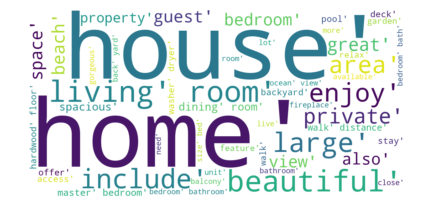

**************************************************
Word Cloud for Topic 6


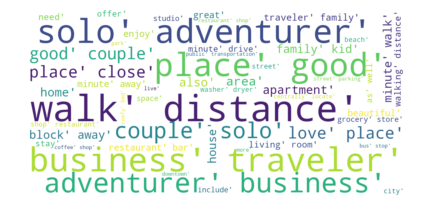

**************************************************
Word Cloud for Topic 4


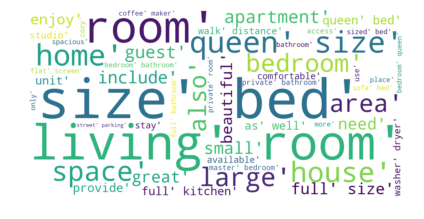

**************************************************
Word Cloud for Topic 3


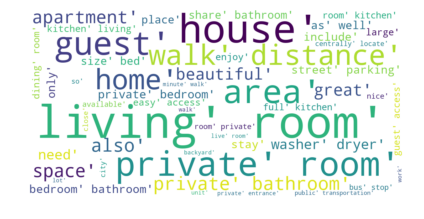

**************************************************
Word Cloud for Topic 5


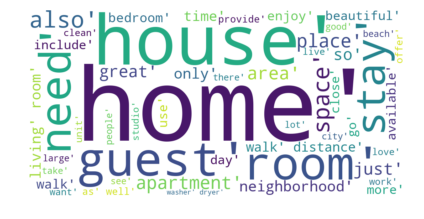

**************************************************
Word Cloud for Topic 8


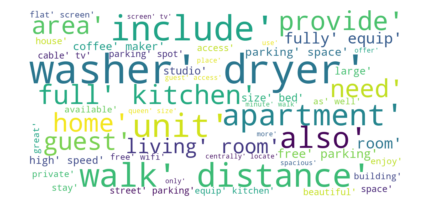

**************************************************
Word Cloud for Topic 1


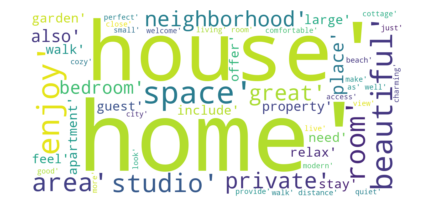

**************************************************
Word Cloud for Topic 7


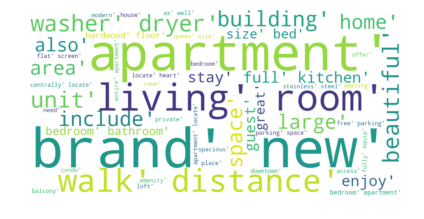

In [23]:
topics = list(df.Topic.unique())

for t in topics:
    print('*'*50)
    subset = df[df['Topic'] == t]
    sub_words = list(sent_to_words(subset.description))
    lemma_words = lemmatization(sub_words)
    
    print(f"Word Cloud for Topic {t}")
    
    wordcloud = WordCloud(max_words=50,
                          background_color="white",
                          width=1200,
                          height=600).generate(str(lemma_words))

    # Display the generated image:
    wordcloud.to_file(f"img/wordclouds/topic_{t}_wordcloud.png")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [24]:
df_final = df[['id','Topic']]
df_final.to_pickle('data/processed/listings_topics.pkl')